In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

## Укажите модель, которая будет использоваться
COCO и MPI - это модели оценки позы тела. COCO имеет 18 точек, а MPI - 15 точек в качестве выходного сигнала.

HAND - это модель оценки ключевых точек руки. Она имеет 22 пункта в качестве выходного сигнала

Убедитесь, что файлы модели доступны в папках.

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [-1,8], [8,9], [9,10], [-1,11], [11,12], [12,13], [14,-1] ]
    

#### Загрузка изображения с несколькими людьми

In [3]:
image1 = cv2.imread("multiple.jpeg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

#### Загрузка модели и передача изображения

In [4]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(
              image1, 
              scalefactor = 1.0 / 255, 
              size=(inWidth, inHeight),
              mean=(0, 0, 0),
              swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

(1, 44, 46, 46)


#### Срез вероятной карты (probability map), из выходных данных, для определенной ключевой точки и построение тепловой карты (после изменения размера)

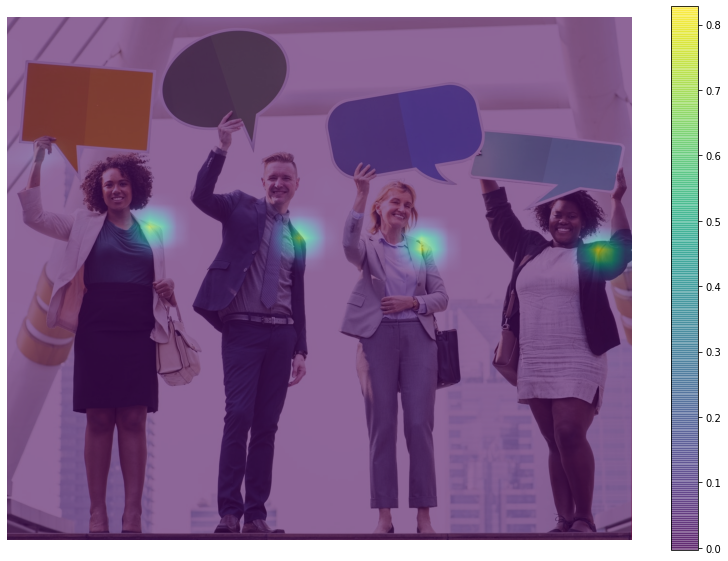

In [5]:
i = 5 # левое плече
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0])) # (46, 46)~~> (1072, 1280)

plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off");

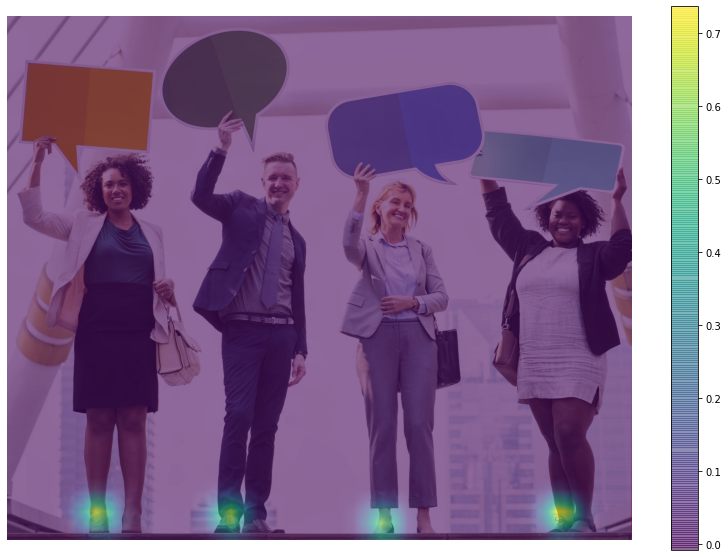

In [6]:
i = 10
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))

plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off");

####  Найдём ключевые точки для изображения только с одним человеком

In [7]:
def findSquaredDist(A, B):
    '''
    Находит квадратное расстояние между двумя точками в 2-D пространстве
     - позволяет избежать потери точности в функции findAngleFromSpine
    '''
    return (A[0]-B[0])**2 + (A[1]-B[1])**2

In [8]:
def findAngleFromSpine(point, A, B):
    '''
    Находит угол, образованный в основании и верхней части позвоночника 
        - большой угол наклона несет в себе риск получения травмы
    returns наибольший угол 
    '''
    a_2 = findSquaredDist(A, point)
    b_2 = findSquaredDist(point, B)
    c_2 = findSquaredDist(A, B)
    
    cos_A = (b_2 + c_2 - a_2)/(2*(b_2*c_2)**0.5)
    angle_A = math.acos(cos_A)* 180 / math.pi # for better debugging converting to degrees
    
    cos_B = (a_2 + c_2 - b_2)/(2*(a_2*c_2)**0.5)
    angle_B = math.acos(cos_B)* 180 / math.pi # for better debugging converting to degrees
    return max(angle_A, angle_B)

In [9]:
## init x, y inputs
x_train_good = []
x_train_bad = []

The average length of the forearm: 97.1
Distance from the bar: 33.5


1	 Shoulder Angle from Spinal Baseline: 13.7 degrees
Chest Angle from Spinal Baseline: 6.46 degrees
Angle formed at shoulder: 59.9 degrees


2	 Shoulder Angle from Spinal Baseline: 3.66 degrees
Chest Angle from Spinal Baseline: 7.31 degrees
Point 2 not found	 good/2.jpg
The average length of the forearm: 82.9
Distance from the bar: 28.0


3	 Shoulder Angle from Spinal Baseline: 23.7 degrees
Chest Angle from Spinal Baseline: 6.12 degrees
Unsafe back form - keep neutral spine
Angle formed at shoulder: 83.7 degrees


4	 Shoulder Angle from Spinal Baseline: 0.0 degrees
Chest Angle from Spinal Baseline: 2.71 degrees
Point 4 not found	 good/4.jpg
Point 4 not found	 good/4.jpg
Point 4 not found	 good/4.jpg
Point 4 not found	 good/4.jpg
The average length of the forearm: 19.3
Distance from the bar: 10.0


5	 Shoulder Angle from Spinal Baseline: 20.1 degrees
Chest Angle from Spinal Baseline: 0.579 degrees
Unsafe back form - k

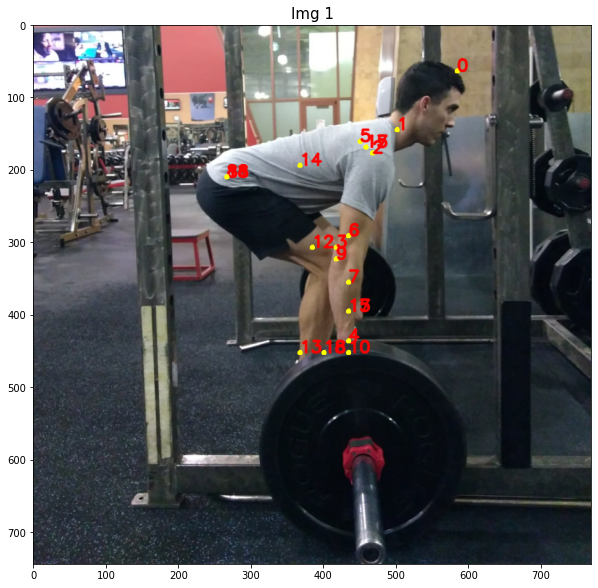

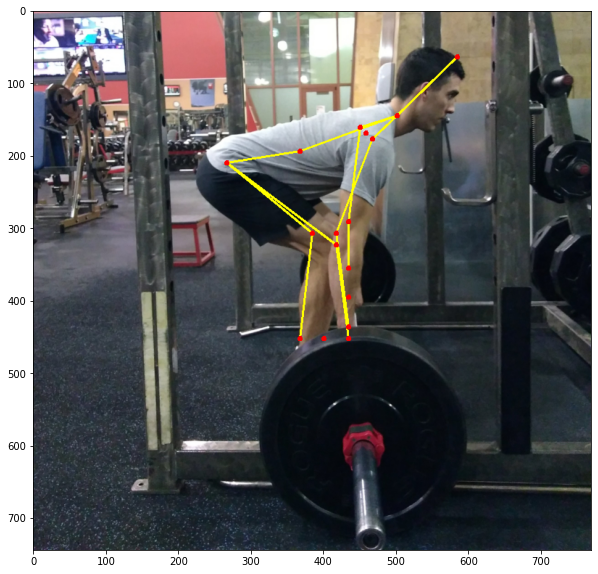

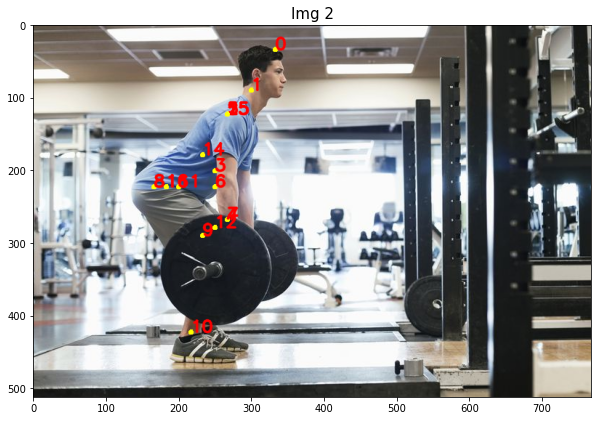

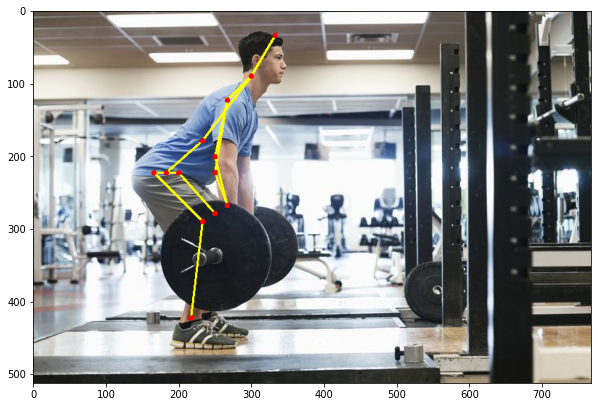

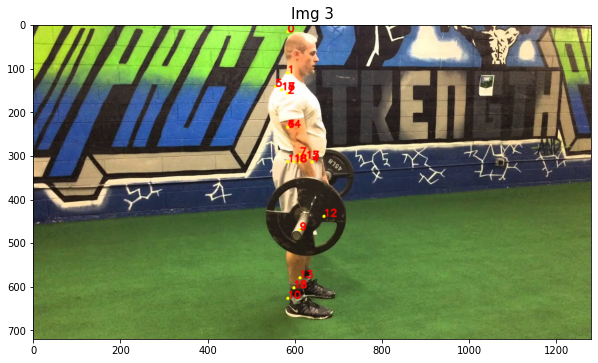

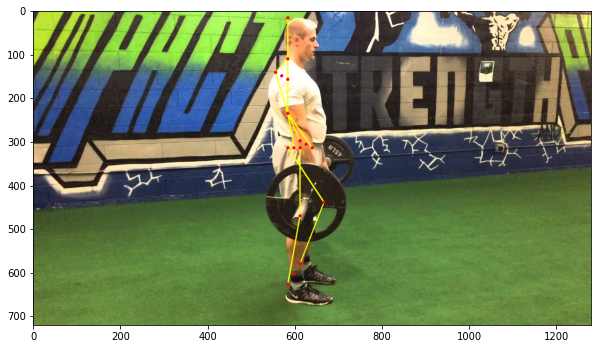

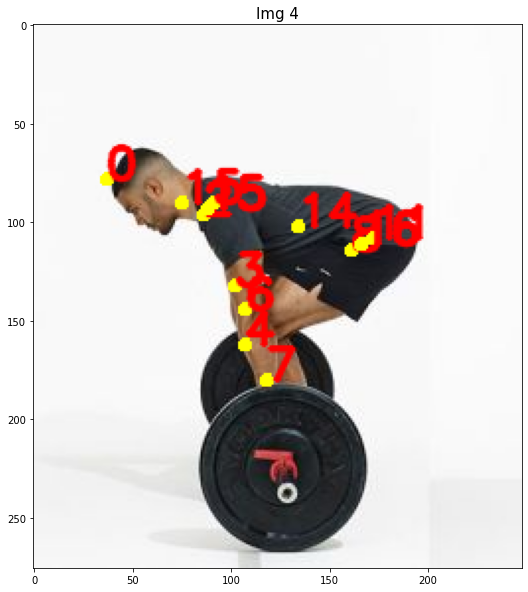

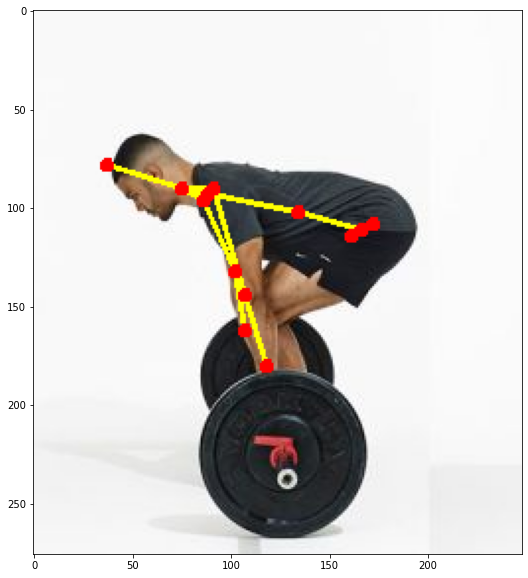

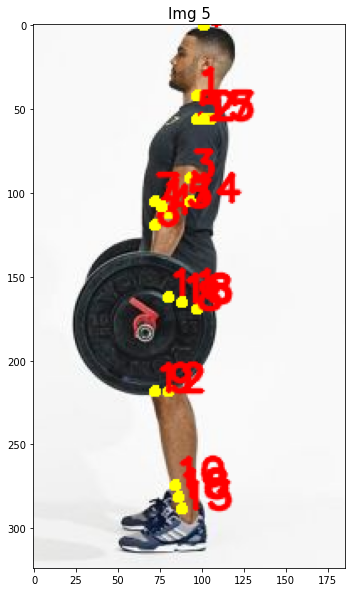

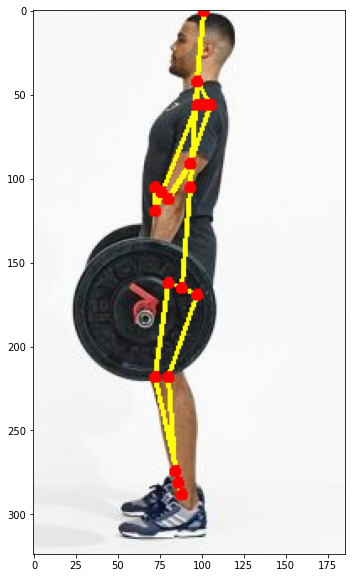

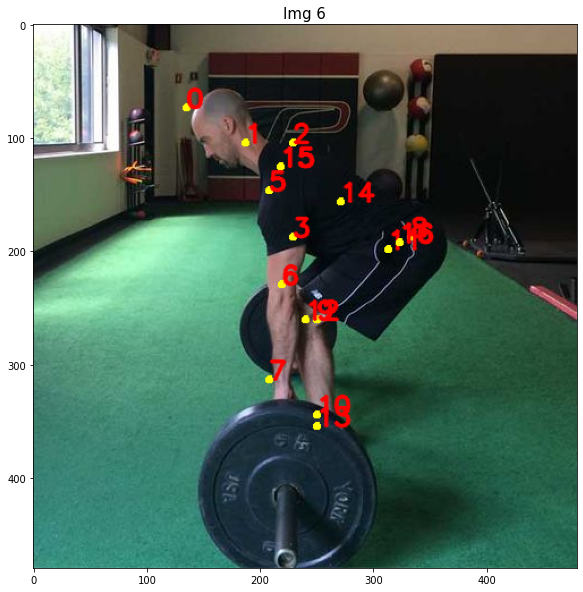

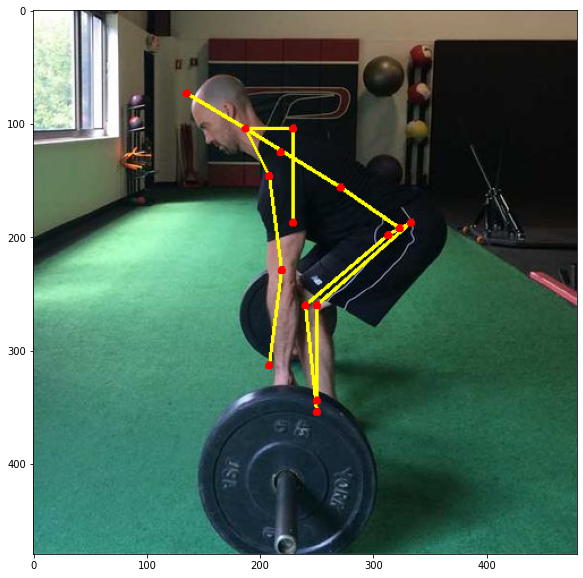

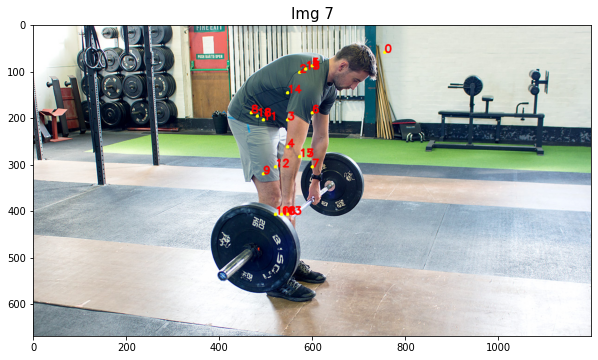

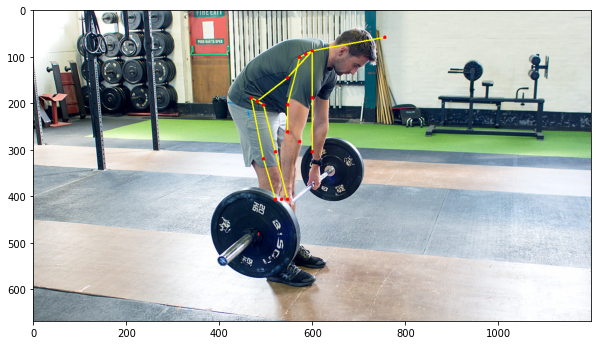

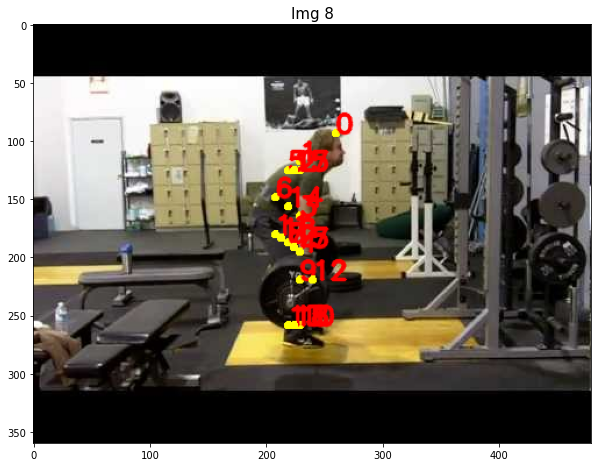

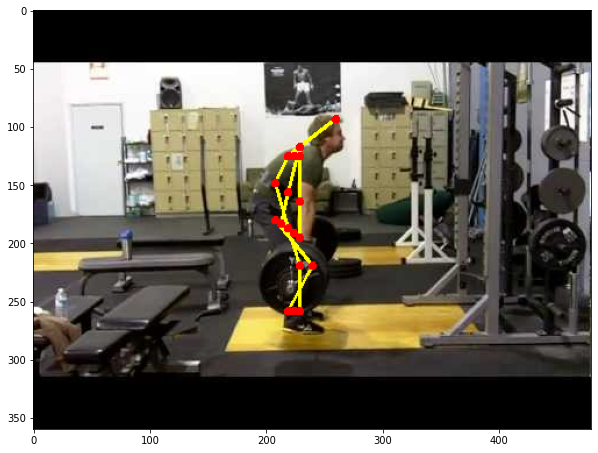

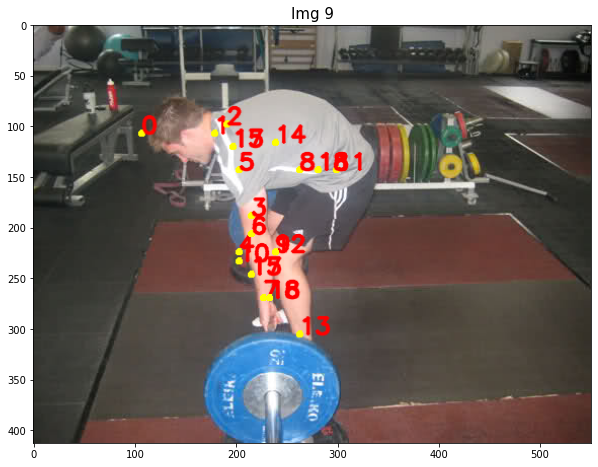

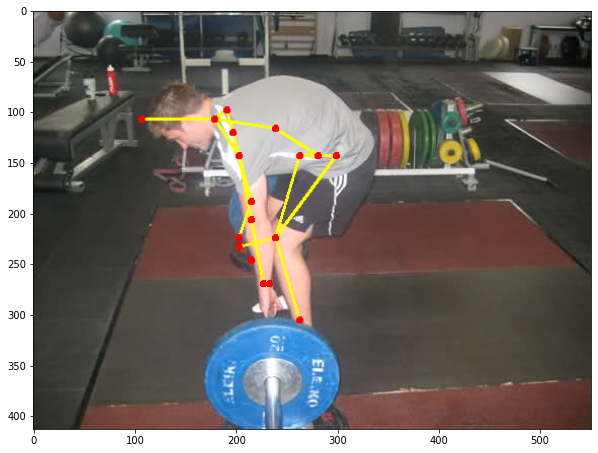

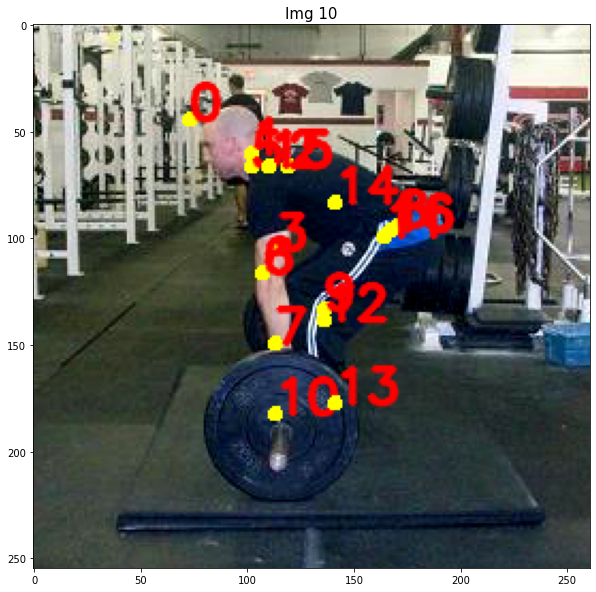

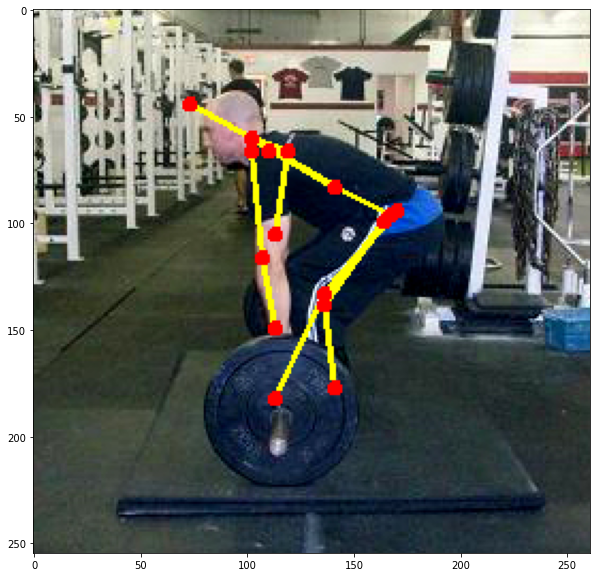

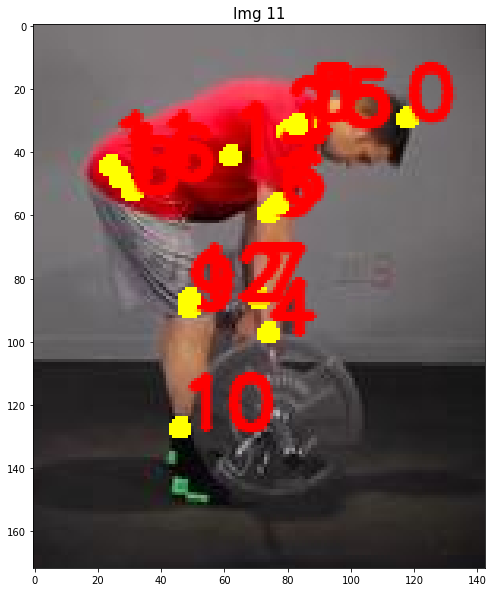

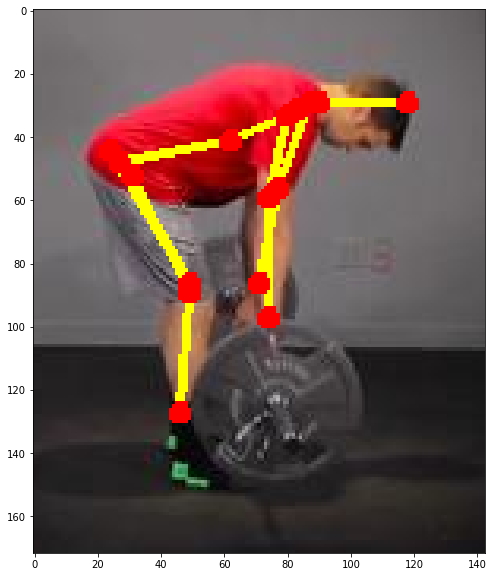

In [17]:
num_good = 6
num_bad = 5

for test_num in range(1,num_good + num_bad + 1):
    if test_num <= num_good:
        label = "good"
        file_path = f"{label}/{test_num}.jpg"
    else:
        label = "bad"
        file_path = f"{label}/{test_num-num_good}.jpg"
    frame = cv2.imread(file_path)
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1

    ## Передача изображения в модель
    inpBlob = cv2.dnn.blobFromImage(
              frame, 
              scalefactor = 1.0 / 255, 
              size=(inWidth, inHeight),
              mean=(0, 0, 0),
              swapRB=False, crop=False)
    net.setInput(inpBlob)

    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]

    ## сбор точек, рисование ключевых точек и фигуры скелета

    points = [] # список для хранения обнаруженных ключевых точек
    for i in range(nPoints):# {15,18}
        # срез карты вероятности i части тела.
        probMap = output[0, i, :, :]

        # Поиск глобальных максимумов вероятностной карты - probMap
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Масштабирование точки, чтобы она поместилась на исходном изображении
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        # Добавление точки в список, если вероятность превышает пороговое значение
        if prob > threshold : 
              points.append((int(x), int(y)))
        else: points.append(None)

    ## BAR DISTANCE (TODO)
    avg_x_wrists = None
    if points[4] and points[7] and points[10] and points[13]: # not running this block now
        right_forearm_len = findSquaredDist(points[3], points[4])**0.5
        left_forearm_len = findSquaredDist(points[6], points[7])**0.5
        avg_forearm_len = (right_forearm_len + left_forearm_len)/2
        # процент длины предплечья для использования, так как штанга должна быть поднята от середины стопы
        # ~> использование длины предплечья в качестве оценки длины стопы
        bar_x_range_from_foot = avg_forearm_len * 75
        print(f'The average length of the forearm: {avg_forearm_len:.3}')
        
        # средняя точка запястий - если снимок сделан под небольшим углом
        avg_x_wrists = (points[4][0] + points[7][0])/2
        avg_y_wrists = (points[4][1] + points[7][1])/2
        points.append((int(avg_x_wrists), int(avg_y_wrists)))
        cv2.circle(frameCopy, (int(avg_x_wrists), int(avg_y_wrists)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(17), (int(avg_x_wrists), int(avg_y_wrists)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(avg_x_wrists), int(avg_y_wrists)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # средняя точка лодыжек - если снимок сделан под небольшим углом
        avg_x_ankles = (points[10][0] + points[13][0])/2
        avg_y_ankles = (points[10][1] + points[13][1])/2
        points.append((int(avg_x_ankles), int(avg_y_ankles)))
        cv2.circle(frameCopy, (int(avg_x_ankles), int(avg_y_ankles)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(18), (int(avg_x_ankles), int(avg_y_ankles)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(avg_x_ankles), int(avg_y_ankles)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        dist_bar = abs(avg_x_wrists - avg_x_ankles)
        print(f"Distance from the bar: {dist_bar}")

    if True:# print Warnings (Unsafe form)
        ## средняя точка плеч
        avg_x = (points[2][0] + points[5][0])/2
        avg_y = (points[2][1] + points[5][1])/2
        points.append((int(avg_x), int(avg_y)))
        cv2.circle(frameCopy, (int(avg_x), int(avg_y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(15), (int(avg_x), int(avg_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(avg_x), int(avg_y)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        ## середина бедер
        avg_x = (points[8][0] + points[11][0])/2
        avg_y = (points[8][1] + points[11][1])/2
        points.append((int(avg_x), int(avg_y)))
        cv2.circle(frameCopy, (int(avg_x), int(avg_y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(16), (int(avg_x), int(avg_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(avg_x), int(avg_y)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        ### BACK FORM
        ## вычисляет угол от позвоночника до середины плеч и груди
        shoulders_angle = findAngleFromSpine(points[-2], points[1], points[-1])
        chest_angle = findAngleFromSpine(points[14], points[1], points[-1])
        print(f"\n\n{test_num}\t Shoulder Angle from Spinal Baseline: {shoulders_angle:.3} degrees")
        print(f"Chest Angle from Spinal Baseline: {chest_angle:.3} degrees")
        spine_threshold = 15 # это может быть изменено для эксперимента
        if max(shoulders_angle, chest_angle) > spine_threshold:
            print("\033[91m{}\033[00m".format("Unsafe back form - keep neutral spine"))

        ## ARM TO SPINAL BASELINE ANGLE
        if avg_x_wrists:
            a_2 = findSquaredDist((avg_x_wrists,avg_y_wrists), points[-2])
            b_2 = findSquaredDist(points[-2], points[-1])
            c_2 = findSquaredDist((avg_x_wrists,avg_y_wrists), points[-1])
            cos_A = (b_2 + c_2 - a_2)/(2*(b_2*c_2)**0.5)
            angle_A = math.acos(cos_A)* 180 / math.pi
            print(f"Angle formed at shoulder: {angle_A:.3} degrees")

    ## Рисование скелета
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]
        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB],
                     color=(0, 255, 255), thickness=2)
            
    for i in range(len(points)):
         if points[i]:
            x = points[i][0]
            y = points[i][1]
            cv2.circle(frameCopy, (int(x), int(y)), 3, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), 3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

    ## Позвоночник
    #cv2.line(frame, points[1], points[-1], (255, 0, 0), 3)

    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
    plt.title(f'Img {test_num}', size=15)
    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if label == "good":
        temp = []
        for i in points[:15]:
            if i:
                temp.append(i[0])
                temp.append(i[1])
            else:
                temp.append(-1)
                temp.append(-1)
                print(f'Point {test_num} not found\t', file_path)
        x_train_good.append(temp)
    else:
        temp = []
        for i in points[:15]:
            if i:
                temp.append(i[0])
                temp.append(i[1])
            else:
                temp.append(-1)
                temp.append(-1)
                print(f'Point {test_num} not found\t', file_path)
        x_train_bad.append(temp)


In [11]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = Ridge(alpha=1.0) #Lasso(alpha=1.0) #LogisticRegression(random_state=1) #ElasticNet(alpha=1.0)

clf.fit(x_train_good+x_train_bad, [1]*len(x_train_good)+[0]*len(x_train_bad))

Ridge()

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

results = clf.predict([
  [333, 33, 300, 89, 267, 122, 250, 200, 267, 267, 267, 
   122, 250, 222, 267, 267, 166, 222, 233, 289, 217, 422,
   200, 222, 250, 278, -1, -1, 233, 178]
])
print(sigmoid((results-0.5)*6)) # для строгого ограничения вероятности

[0.95258941]


In [13]:
inWidth = 368
inHeight = 368
threshold = 0.1


input_source = "e.mp4"
cap = cv2.VideoCapture(input_source)
hasFrame, frame = cap.read()
vid_writer = cv2.VideoWriter('output.avi',
                             fourcc=cv2.VideoWriter_fourcc('M','J','P','G'),
                             fps=2, frameSize=(frame.shape[1],frame.shape[0]))

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
counter = 0
while cv2.waitKey(1) < 0:
    t = time.time()
    hasFrame, frame = cap.read()
    frameCopy = np.copy(frame)
    if not hasFrame:
        cv2.waitKey()
        break

    frameWidth  = frame.shape[1]
    frameHeight = frame.shape[0]
    
    ## Передача изображения в модель
    inpBlob = cv2.dnn.blobFromImage(
              frame, 
              scalefactor = 1.0 / 255, 
              size=(inWidth, inHeight),
              mean=(0, 0, 0),
              swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]

    ## сбор точек, рисование ключевых точкек и фигуры скелета
    points = [] # список для хранения обнаруженных ключевых точек
    for i in range(nPoints):# {15,18}
        # срез карты вероятности i части тела.
        probMap = output[0, i, :, :]

        # Поиск глобальных максимумов вероятностной карты - probMap
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Масштабирование точки, чтобы она поместилась на исходном изображении
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        # Добавление точки в список, если вероятность превышает пороговое значение
        if prob > threshold : 
              points.append((int(x), int(y)))
        else: points.append(None)
            
    # Рисование скелета
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3, lineType=cv2.LINE_AA)
            cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
    
    temp = []
    for i in points:
        if i:
            temp.append(i[0])
            temp.append(i[1])
        else:
            temp.append(-1)
            temp.append(-1)
    result = clf.predict([temp])
    
    cv2.putText(frame, "Time taken = {:.2f} sec".format(time.time() - t), (50, 50), cv2.FONT_HERSHEY_COMPLEX, .8, (0, 0, 0), 2, lineType=cv2.LINE_AA)
    cv2.putText(frame, "Prediction: " + str(sigmoid((result-0.5)*6)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, .8, (0, 0, 0), 2, lineType=cv2.LINE_AA)

    # cv2.imshow('Output-Keypoints', frameCopy)
    # cv2.imshow('Output-Skeleton', frame)

    print('Writing frame', counter)
    vid_writer.write(frame)
    print('  Wrote frame',counter)
    counter += 1
print('Releasing')
vid_writer.release()
print('Done')

Writing frame 0
  Wrote frame 0
Writing frame 1
  Wrote frame 1
Writing frame 2
  Wrote frame 2
Writing frame 3
  Wrote frame 3
Writing frame 4
  Wrote frame 4
Writing frame 5
  Wrote frame 5
Releasing
Done
